# Deep Learning: Telecom Customer Churn Prediction

* Summary and basic information of the data
* Replace null values and perform exploratoy data analysis
* Transform skewed variables, categorical and binary features
* Dimensionality reduction (PCA)
* Make prediction using Logistic Regression, NN, CNN

data source: https://www.kaggle.com/jpacse/datasets-for-churn-telecom

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from sklearn import metrics
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data Summary

In [2]:
# load data
path = os.getcwd()
file = os.sep.join([path] + ['cell2celltrain.csv'])
data = pd.read_csv(file)

In [3]:
data.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 51047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             50891 non-null  float64
 3   MonthlyMinutes             50891 non-null  float64
 4   TotalRecurringCharge       50891 non-null  float64
 5   DirectorAssistedCalls      50891 non-null  float64
 6   OverageMinutes             50891 non-null  float64
 7   RoamingCalls               50891 non-null  float64
 8   PercChangeMinutes          50680 non-null  float64
 9   PercChangeRevenues         50680 non-null  float64
 10  DroppedCalls               51047 non-null  float64
 11  BlockedCalls               51047 non-null  float64
 12  UnansweredCalls            51047 non-null  float64
 13  CustomerCareCalls          51047 non-null  flo

In [5]:
# number of missing value
na_cols = data.columns[data.isnull().sum() != 0]
data[na_cols].isnull().sum()

MonthlyRevenue           156
MonthlyMinutes           156
TotalRecurringCharge     156
DirectorAssistedCalls    156
OverageMinutes           156
RoamingCalls             156
PercChangeMinutes        367
PercChangeRevenues       367
ServiceArea               24
Handsets                   1
HandsetModels              1
CurrentEquipmentDays       1
AgeHH1                   909
AgeHH2                   909
dtype: int64

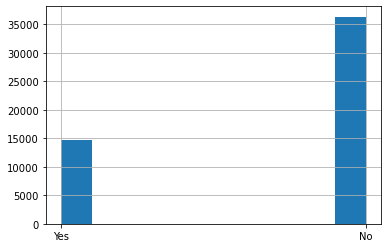

In [6]:
data.Churn.hist();

In [7]:
data.Churn.value_counts(normalize = True)

No     0.711815
Yes    0.288185
Name: Churn, dtype: float64

## Data Cleaning and EDA

In [8]:
# drop customer ID and service area
data.drop(columns = ['CustomerID', 'ServiceArea'], inplace = True)

In [9]:
# replace missing values in numerical columns with 0
for col in na_cols:
    if col != 'ServiceArea':
        data[col].fillna(0, inplace = True)

In [10]:
# numerical columns and non-numerical columns
num_cols = data.columns[data.dtypes != 'object']
obj_cols = data.columns[data.dtypes == 'object']

In [11]:
num_cols

Index(['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge',
       'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls',
       'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls',
       'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls',
       'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut',
       'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls',
       'CallWaitingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs',
       'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2',
       'RetentionCalls', 'RetentionOffersAccepted',
       'ReferralsMadeBySubscriber', 'IncomeGroup',
       'AdjustmentsToCreditRating'],
      dtype='object')

### Numerical Features

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyRevenue,51047.0,58.654694,44.557776,-6.17,33.5,48.29,70.96,1223.38
MonthlyMinutes,51047.0,524.047015,529.855789,0.00,156.0,365.00,722.00,7359.00
TotalRecurringCharge,51047.0,46.686975,23.952288,-11.00,30.0,45.00,60.00,400.00
DirectorAssistedCalls,51047.0,0.892493,2.225687,0.00,0.0,0.25,0.99,159.39
OverageMinutes,51047.0,39.905460,96.465678,0.00,0.0,2.00,40.00,4321.00
RoamingCalls,51047.0,1.232466,9.803517,0.00,0.0,0.00,0.20,1112.40
PercChangeMinutes,51047.0,-11.464885,256.589244,-3875.00,-82.0,-4.00,65.00,5192.00
PercChangeRevenues,51047.0,-1.183415,39.432523,-1107.70,-6.9,-0.30,1.55,2483.50
DroppedCalls,51047.0,6.011489,9.043955,0.00,0.7,3.00,7.70,221.70
BlockedCalls,51047.0,4.085672,10.946905,0.00,0.0,1.00,3.70,384.30


In [13]:
# log transform skewed variables
skew = data[num_cols].skew().sort_values(ascending = False)
skew = skew[skew > 0.75].index.tolist()
skew

['CallForwardingCalls',
 'UniqueSubs',
 'RoamingCalls',
 'ReferralsMadeBySubscriber',
 'AdjustmentsToCreditRating',
 'ThreewayCalls',
 'CustomerCareCalls',
 'DirectorAssistedCalls',
 'CallWaitingCalls',
 'ActiveSubs',
 'BlockedCalls',
 'RetentionOffersAccepted',
 'OverageMinutes',
 'PercChangeRevenues',
 'RetentionCalls',
 'InboundCalls',
 'DroppedBlockedCalls',
 'DroppedCalls',
 'UnansweredCalls',
 'MonthlyRevenue',
 'OutboundCalls',
 'OffPeakCallsInOut',
 'PeakCallsInOut',
 'Handsets',
 'ReceivedCalls',
 'HandsetModels',
 'MonthlyMinutes',
 'TotalRecurringCharge',
 'CurrentEquipmentDays',
 'MonthsInService']

In [14]:
for c in skew:
    if data[c].min() < 0:
        data[c] = data[c] - data[c].min()
    data[c] = data[c].apply(np.log1p)

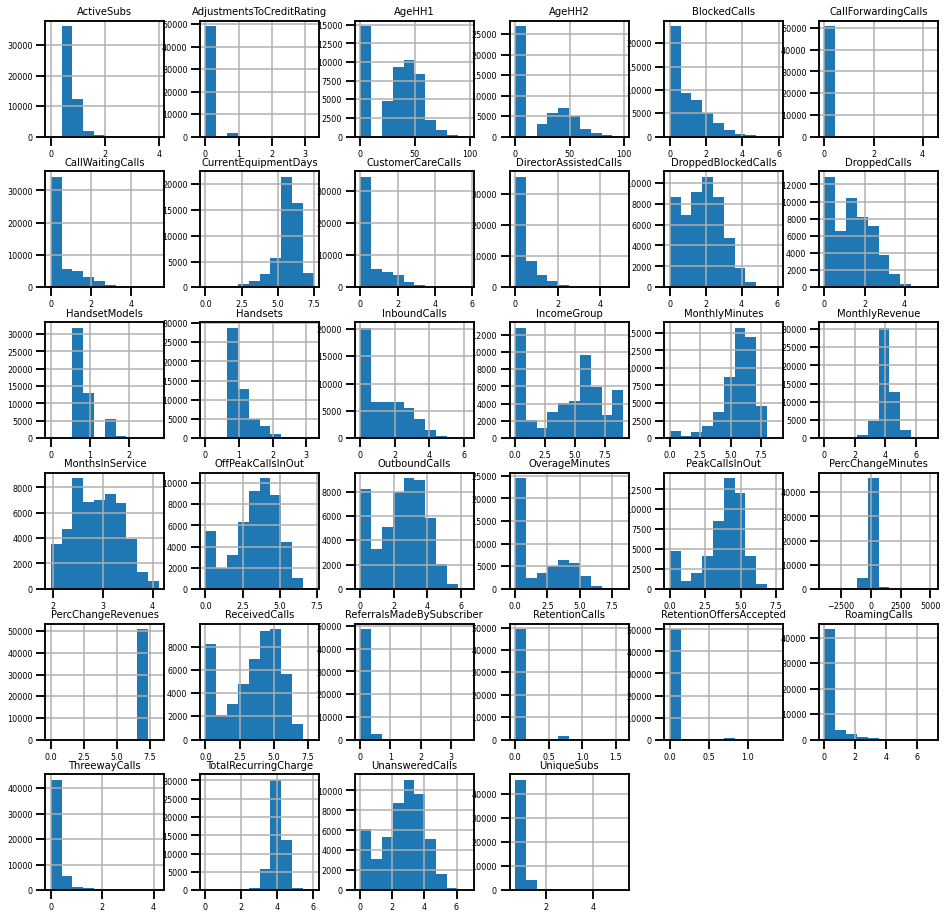

In [35]:
params = {'axes.titlesize':'10',
          'xtick.labelsize':'8',
          'ytick.labelsize':'8'}
matplotlib.rcParams.update(params)
data[num_cols].hist(figsize = (16, 16));
plt.savefig('his.png')

### Non-numerical Features

In [36]:
data['Churn'] = data['Churn'].replace({'Yes':1, 'No': 0})

0        Yes
1        Yes
2         No
3         No
4        Yes
        ... 
51042    Yes
51043     No
51044    Yes
51045     No
51046     No
Name: Churn, Length: 51047, dtype: object

In [283]:
uniq_val = pd.DataFrame([[c, len(data[c].unique())] for c in data[obj_cols].columns], 
                        columns = ['Variable', 'Number']).set_index('Variable')

In [285]:
# binary features
bin_cols = uniq_val[uniq_val.Number == 2].index.tolist()
bin_cols

['ChildrenInHH',
 'HandsetRefurbished',
 'HandsetWebCapable',
 'TruckOwner',
 'RVOwner',
 'Homeownership',
 'BuysViaMailOrder',
 'RespondsToMailOffers',
 'OptOutMailings',
 'NonUSTravel',
 'OwnsComputer',
 'HasCreditCard',
 'NewCellphoneUser',
 'NotNewCellphoneUser',
 'OwnsMotorcycle',
 'MadeCallToRetentionTeam']

In [286]:
# binarize binary columns
for c in bin_cols:
    data[c] = LabelBinarizer().fit_transform(data[c])

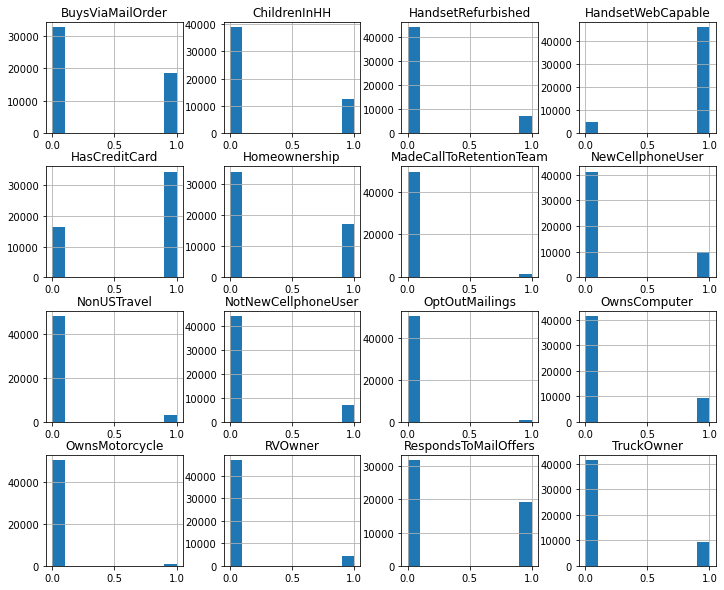

In [315]:
# plot distribution of binary variables
data[bin_cols].hist(figsize = (12, 10));
plt.savefig('bin_hist.png')

In [287]:
# other categorical features
other_cols = uniq_val[uniq_val.Number > 2].index.tolist()
other_cols

['HandsetPrice', 'CreditRating', 'PrizmCode', 'Occupation', 'MaritalStatus']

In [288]:
# ordinal variable
data.CreditRating.value_counts(normalize = True)

2-High       0.372069
1-Highest    0.166944
3-Good       0.164750
5-Low        0.127314
4-Medium     0.104943
7-Lowest     0.041413
6-VeryLow    0.022567
Name: CreditRating, dtype: float64

In [289]:
# transform to int
data['CreditRating'] = [x[0] for x in data['CreditRating']]
data['CreditRating'] = LabelEncoder().fit_transform(data['CreditRating'])

In [290]:
# one-hot encode other columns
other_cols.remove('CreditRating')
data = pd.get_dummies(data, columns = other_cols, drop_first=True)

## Feature Engineering

In [295]:
# scale features
y = data.Churn
s = MinMaxScaler()
X = data.copy()
X.drop(columns = ['Churn'])
X = s.fit_transform(X)

In [302]:
X.shape

(51047, 79)

### PCA

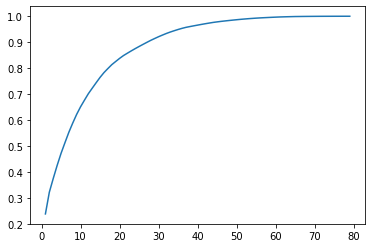

In [312]:
# plot the explained variance
X1 = X
var = []
for n in range(1, 80):
    pca = PCA(n_components = n)
    x = pca.fit_transform(X1)
    var.append(pca.explained_variance_ratio_.sum())

plt.plot(range(1, 80), var)
plt.savefig('var.png')

In [335]:
# choose n = 30
pca = PCA(n_components = 30)
X1 = pca.fit_transform(X)
pca.explained_variance_ratio_.sum()

0.9211085812258075

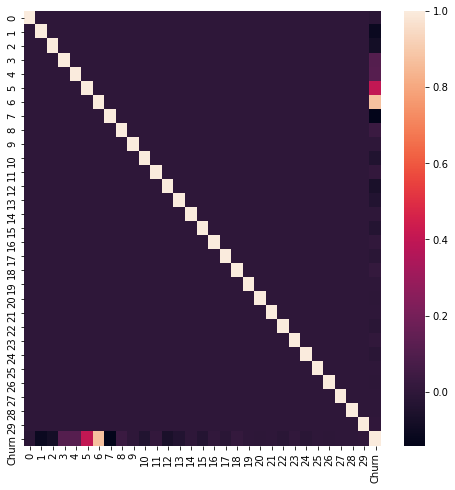

In [425]:
# visualize correlations between features and label
data1 = pd.DataFrame(X1)
data1['Churn'] = data.Churn
corr = data1.corr()
plt.figure(figsize = (8, 8))
sns.heatmap(corr);
plt.savefig('heat.png')

In [426]:
data1.shape

(51047, 31)

## Training

In [427]:
# stratified split
data1.drop(columns = ['Churn'], inplace = True)

sp = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 708)
t, test = next(sp.split(data1, y))
# get training and testing data
X_t = data1.iloc[t, :]
X_test = data1.iloc[test, :]
y_t = y.iloc[t]
y_test = y.iloc[test]

In [428]:
X_t.shape

(35732, 30)

In [429]:
# split again to get validation data
sp = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 798)
train, val = next(sp.split(X_t, y_t))
# get training and validation data
X_train = X_t.iloc[train, :]
X_val = X_t.iloc[val, :]
y_train = y_t.iloc[train]
y_val = y_t.iloc[val]

In [509]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(25012, 30)
(10720, 30)
(15315, 30)


### Logistic Regression

In [513]:
lr = LogisticRegression(penalty = 'l2', solver = 'liblinear')
lr.fit(X_t, y_t)

LogisticRegression(solver='liblinear')

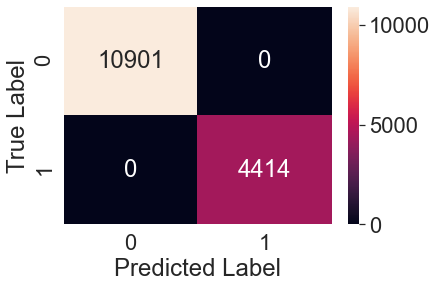

In [514]:
test_pred = lr.predict(X_test)
cm_test = metrics.confusion_matrix(y_test, test_pred)
sns.set(font_scale=2)
sns.heatmap(cm_test, annot = True, fmt = 'd');
plt.xlabel('Predicted Label');
plt.ylabel('True Label');

### Model 1

In [489]:
# simple neural netwrok
in_shape = (30,)
out_dim = 1

m1 = Sequential()
m1.add(Dense(512, input_shape = in_shape))
m1.add(Activation('relu'))
m1.add(Dropout(0.5))
m1.add(Dense(out_dim))
m1.add(Activation('sigmoid'))
m1.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 512)               15872     
_________________________________________________________________
activation_33 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 513       
_________________________________________________________________
activation_34 (Activation)   (None, 1)                 0         
Total params: 16,385
Trainable params: 16,385
Non-trainable params: 0
_________________________________________________________________


In [490]:
batch = 32
opt = tensorflow.keras.optimizers.Adam()
m1.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
m1.fit(X_train, y_train,
              batch_size=batch,
              epochs=1,
              validation_data=(X_val, y_val),
              shuffle=True)

Train on 25012 samples, validate on 10720 samples
25012/25012 [==============================] - 4s 158us/sample - loss: 0.0596 - accuracy: 0.9808 - val_loss: 7.6612e-04 - val_accuracy: 1.0000


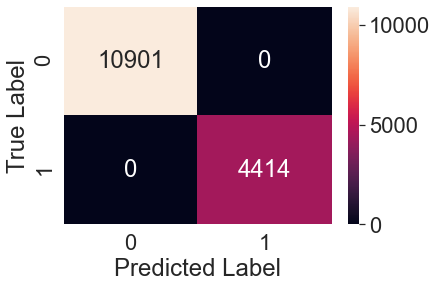

In [491]:
cm1 = metrics.confusion_matrix(y_test, np.round(pred1))
sns.set(font_scale=2)
sns.heatmap(cm1, annot = True, fmt = 'd');
plt.xlabel('Predicted Label');
plt.ylabel('True Label');

### Model 2

In [492]:
in_shape = (30,)
out_dim = 1

m2 = Sequential()
m2.add(Dense(16, input_shape = in_shape))
m2.add(Activation('relu'))
m2.add(Dropout(0.5))
m2.add(Dense(out_dim))
m2.add(Activation('sigmoid'))
m2.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 16)                496       
_________________________________________________________________
activation_35 (Activation)   (None, 16)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 17        
_________________________________________________________________
activation_36 (Activation)   (None, 1)                 0         
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [493]:
batch = 512
opt = tensorflow.keras.optimizers.Adam()
m1.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
m1.fit(X_train, y_train,
              batch_size=batch,
              epochs=1,
              validation_data=(X_val, y_val),
              shuffle=True)

Train on 25012 samples, validate on 10720 samples
25012/25012 [==============================] - 1s 55us/sample - loss: 2.6407e-04 - accuracy: 1.0000 - val_loss: 3.6971e-05 - val_accuracy: 1.0000


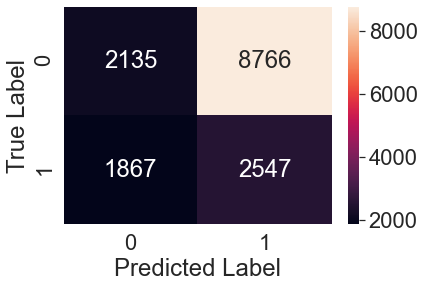

In [511]:
pred2 = m2.predict(X_test)
cm2 = metrics.confusion_matrix(y_test, np.round(pred2))
sns.set(font_scale=2)
sns.heatmap(cm2, annot = True, fmt = 'd');
plt.xlabel('Predicted Label');
plt.ylabel('True Label');

### CNN

In [496]:
m3 = Sequential()
m3.add(Conv1D(32, 5, padding = 'same', input_shape = (1, 30)))
m3.add(Activation('relu'))
m3.add(Flatten())
m3.add(Dense(out_dim))
m3.add(Activation('sigmoid'))
m3.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 1, 32)             4832      
_________________________________________________________________
activation_37 (Activation)   (None, 1, 32)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 33        
_________________________________________________________________
activation_38 (Activation)   (None, 1)                 0         
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [499]:
batch = 512
# reshape X, y for convolutional layer
X_3d_train = X_train.to_numpy().reshape(X_train.shape[0], 1, X_train.shape[1])
X_3d_val = X_val.to_numpy().reshape(X_val.shape[0], 1, X_val.shape[1])
y_3d_train = y_train.to_numpy()
y_3d_val = y_val.to_numpy()

opt = tensorflow.keras.optimizers.Adam()
m3.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
m3.fit(X_3d_train, y_3d_train,
              batch_size=batch,
              epochs=1,
              validation_data=(X_3d_val, y_3d_val))

Train on 25012 samples, validate on 10720 samples
25012/25012 [==============================] - 1s 52us/sample - loss: 0.6113 - accuracy: 0.7444 - val_loss: 0.5436 - val_accuracy: 0.7776


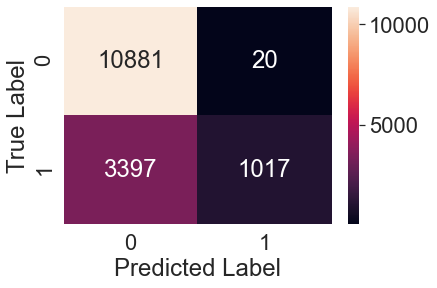

In [512]:
X_3d_test = X_test.to_numpy().reshape(X_test.shape[0], 1, X_test.shape[1])
y_3d_test = y_test.to_numpy()

pred3 = m3.predict(X_3d_test)
cm3 = metrics.confusion_matrix(y_3d_test, np.round(pred3))
sns.set(font_scale=2)
sns.heatmap(cm3, annot = True, fmt = 'd');
plt.xlabel('Predicted Label');
plt.ylabel('True Label');